In [51]:
# Imports, settings
from src.data import load
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import spacy
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, recall_score, make_scorer, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.externals import joblib
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from skorch import NeuralNetClassifier

# Plot dimensions
dims = (11.7, 20)

# Ignore warnings
warnings.simplefilter("ignore")

In [14]:
# Helper functions 

def analyze_dataset(dataset):
    """Analyze the dataset and generate visualizations
    
    :param dataset: Pandas dataframe to be analyzed
    """
    display(dataset.head())
    display(dataset.describe())
    
    f, (ax1, ax2) = plt.subplots(2, figsize=dims)
    
    sns.countplot(
        x='coarse_category',
        data=dataset,
        order=dataset['coarse_category'].value_counts().index,
        ax=ax1)
    
    sns.countplot(
        y="fine_category",
        data=dataset,
        order=dataset['fine_category'].value_counts().index,
        ax=ax2)
    
    plt.show()

In [15]:
# Custom classes for transformation

# Custom vectorizer
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, pretrained=None):
        self.vector_size = vector_size
        self.tokenizer = spacy.load('en')
        self.use_pretrained = False
        
        if pretrained:
            self.use_pretrained = True
            self.word2vec = pretrained
            self.vector_size = self.word2vec.vector_size
        
    def _pre_process(self, X):
        sentences = [x.lower().replace('[^\w\s]','') for x in X['question']]
        sentences = [self.tokenizer.tokenizer(x) for x in sentences]
        sentences = [[str(v) for v in x]  for x in sentences]
        return sentences

    def fit(self, X, y=None):
        if not self.use_pretrained:
            sentences = self._pre_process(X)
            model = Word2Vec(sentences, size=self.vector_size)

            word2vec = dict(zip(model.wv.index2word, model.wv.vectors))

            self.word2vec = word2vec
        
        return self

    def transform(self, X):
        sentences = self._pre_process(X)
        
        if self.use_pretrained:
            return np.array([
                np.mean([self.word2vec.get_vector(w) for w in words if str(w) in self.word2vec]
                        or [np.zeros(self.vector_size)], axis=0)
                for words in sentences
            ])
            
        else:
            
            return np.array([
                np.mean([self.word2vec[w] for w in words if str(w) in self.word2vec]
                        or [np.zeros(self.vector_size)], axis=0)
                for words in sentences
            ])

In [52]:
# custom classes for learners

# Custom LSTM classifier based on torch (will be wrapped in sklearn with skorch)
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size, use_gpu):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.use_gpu = use_gpu

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        if self.use_gpu:
            h0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda())
            c0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim))
            c0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim))
        return (h0, c0)

    def forward(self, X, **kwargs):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        return y

In [16]:
# Load data

train_data = load('data/train_5500.label.txt')
test_data = load('data/test_TREC_10.label.txt')

,coarse_category,fine_category,question
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...
4,ABBR,ABBR:exp,What is the full form of .com ?


,coarse_category,fine_category,question
count,5452,5452,5452
unique,6,50,5381
top,ENTY,HUM:ind,What is the oldest website on the Internet ?
freq,1250,962,3


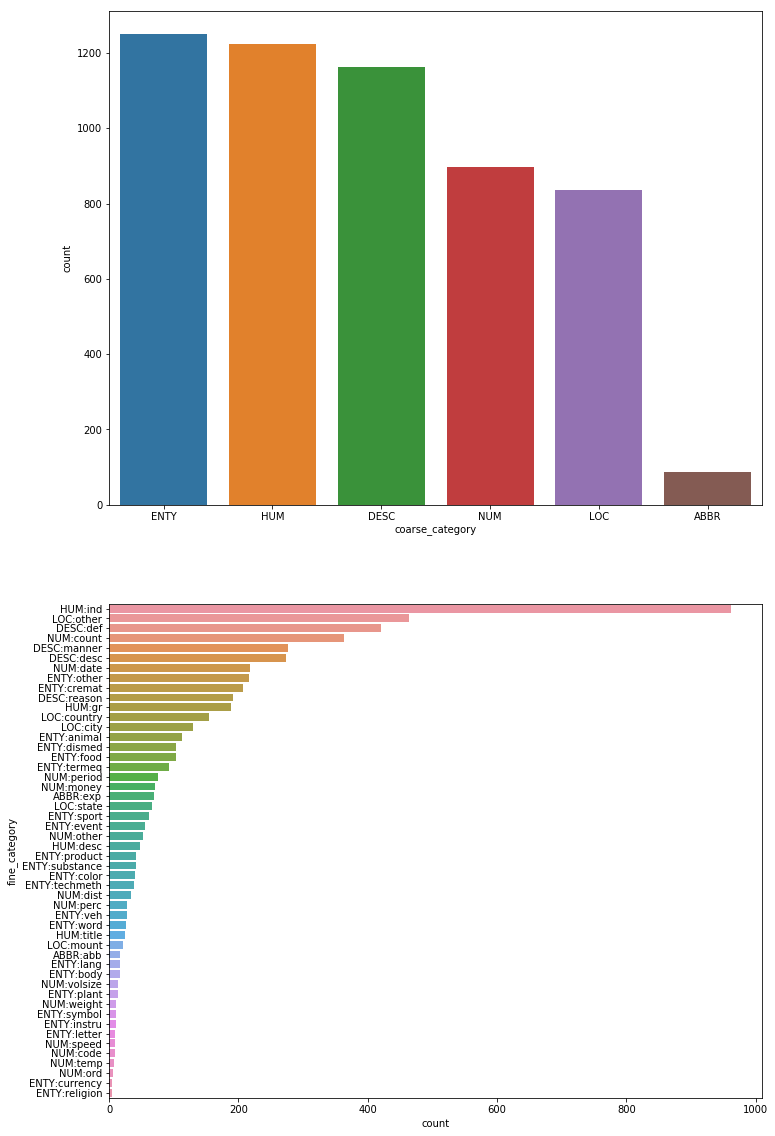

In [17]:
# Examine train data
analyze_dataset(train_data)

### Notes
- Text is not normalized
- There are duplicate rows

,coarse_category,fine_category,question
0,NUM,NUM:dist,How far is it from Denver to Aspen ?
1,LOC,LOC:city,"What county is Modesto , California in ?"
2,HUM,HUM:desc,Who was Galileo ?
3,DESC,DESC:def,What is an atom ?
4,NUM,NUM:date,When did Hawaii become a state ?


,coarse_category,fine_category,question
count,500,500,500
unique,6,42,500
top,DESC,DESC:def,How far away is the moon ?
freq,138,123,1


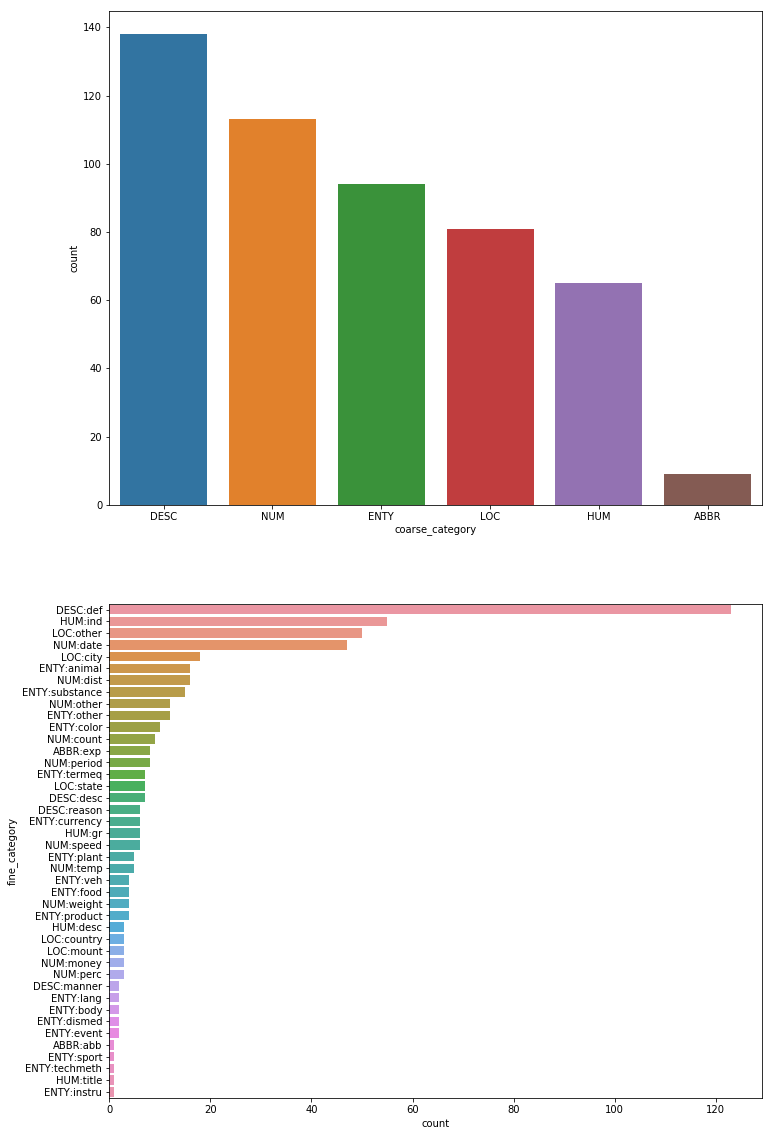

In [18]:
# Analyze test data
analyze_dataset(test_data)

### Notes
- Frequency of labels different from training set

In [19]:
# Examine label intersection
print(set(train_data['coarse_category']) - set(test_data['coarse_category']))
print(set(train_data['fine_category']) - set(test_data['fine_category']))

set()
{'ENTY:symbol', 'ENTY:letter', 'ENTY:cremat', 'NUM:volsize', 'ENTY:word', 'NUM:ord', 'ENTY:religion', 'NUM:code'}


### Notes
- 8 fine category labels not present in test set

,coarse_category,fine_category,question
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...
4,ABBR,ABBR:exp,What is the full form of .com ?


,coarse_category,fine_category,question
count,5382,5382,5382
unique,6,50,5381
top,ENTY,HUM:ind,What is the chromosome number of an elephant ?
freq,1245,956,2


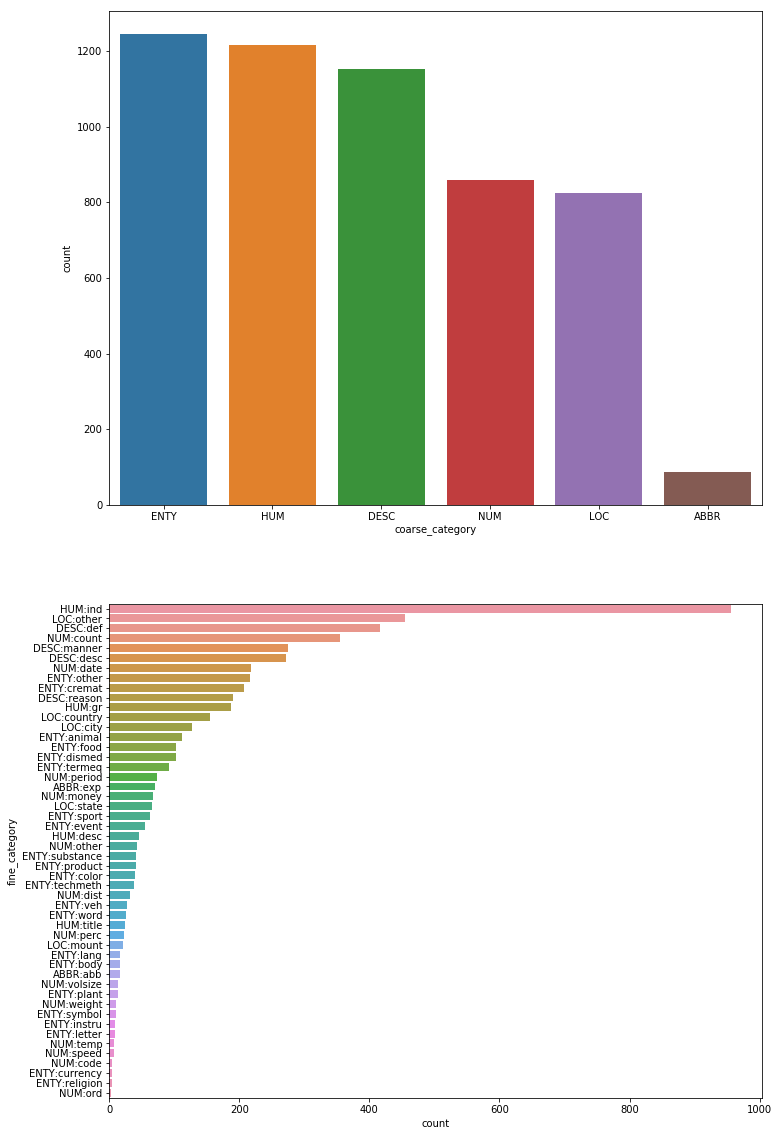

In [20]:
# De duplicate
train_data = train_data.drop_duplicates()
analyze_dataset(train_data)

In [21]:
# Remove the record with ambiguity

train_data = train_data.loc[train_data['question'] != 'What is the chromosome number of an elephant ?']

## Experimentation

### Coarse
Baseline: Most frequent

Metric: Precision

Value: 0.276

### Fine
Baseline: Most frequent

Metric: Precision

Value: 0.246

In [22]:
# Load pretrained vector
#cglove = {}
#with open("data/glove.6B.50d.txt", "rb") as lines:
#    glove = {line.split()[0]: np.array(map(float, line.split()[1:])) for line in lines}

In [23]:
google = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)  

In [48]:
# Experiment with coarse classifier
# Could use gridsearchcv but don't want to mess with pipeline param passing
    
param_grid = ParameterGrid({
    'n_estimators' : [50, 100, 200],
    'learning_rate' : [0.01, 0.1, 1],
    'pretrained' : [google]
})

labels = test_data.coarse_category.unique()

result_dict = {'settings': [],
              'precision_micro': [], 'precision_macro': [],
              'recall_micro': [], 'recall_macro': [],
              'accuracy': []}

for params in param_grid:
    
    print('n_estimators size: {}'.format(params['n_estimators']))
    print('learning_rate: {}'.format(params['learning_rate']))
    print('pretrained: {}'.format(str(type(params['pretrained']))))
    
    coarse_pipe = Pipeline([
        ('vectorizer', MeanEmbeddingVectorizer(pretrained=params['pretrained'])),
        ('estimator', XGBClassifier(n_jobs=-1, n_estimators=params['n_estimators'], learning_rate=params['learning_rate']))])
    
    result_dict['settings'].append(coarse_pipe.get_params())
    
    coarse_pipe.fit(train_data, train_data['coarse_category'])
    predictions = coarse_pipe.predict(test_data)
    
    result_dict['precision_micro'].append(precision_score(test_data['coarse_category'], predictions, average='micro'))
    result_dict['precision_macro'].append(precision_score(test_data['coarse_category'], predictions, average='macro'))
    result_dict['recall_micro'].append(recall_score(test_data['coarse_category'], predictions, average='micro'))
    result_dict['recall_macro'].append(recall_score(test_data['coarse_category'], predictions, average='macro'))
    result_dict['accuracy'].append(accuracy_score(test_data['coarse_category'], predictions))
    
    print('---------------------')

n_estimators size: 50
learning_rate: 0.01
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 100
learning_rate: 0.01
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 200
learning_rate: 0.01
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 50
learning_rate: 0.1
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 100
learning_rate: 0.1
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 200
learning_rate: 0.1
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 50
learning_rate: 1
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
---------------------
n_estimators size: 100
learning_rate: 1
pretrained: <class 'gens

In [49]:
pd.DataFrame(result_dict)

,settings,precision_micro,precision_macro,recall_micro,recall_macro,accuracy
0,"{'memory': None, 'steps': [('vectorizer', Mean...",0.566,0.583401,0.566,0.546422,0.566
1,"{'memory': None, 'steps': [('vectorizer', Mean...",0.602,0.624918,0.602,0.593548,0.602
2,"{'memory': None, 'steps': [('vectorizer', Mean...",0.632,0.652616,0.632,0.637890,0.632
3,"{'memory': None, 'steps': [('vectorizer', Mean...",0.690,0.753083,0.690,0.673357,0.690
4,"{'memory': None, 'steps': [('vectorizer', Mean...",0.762,0.807062,0.762,0.748057,0.762
5,"{'memory': None, 'steps': [('vectorizer', Mean...",0.790,0.825867,0.790,0.787168,0.790
6,"{'memory': None, 'steps': [('vectorizer', Mean...",0.734,0.765330,0.734,0.740988,0.734
7,"{'memory': None, 'steps': [('vectorizer', Mean...",0.762,0.788246,0.762,0.767932,0.762
8,"{'memory': None, 'steps': [('vectorizer', Mean...",0.784,0.805341,0.784,0.790275,0.784


In [26]:
# Experiment with fine classifier
param_grid = ParameterGrid({
    'vector_size' : [50],
    'n_estimators' : [50, 100, 200, 300],
    'pretrained' : [google]
})

labels = test_data.fine_category.unique()

for params in param_grid:
    print('vector_size: {}'.format(params['vector_size']))
    print('n_estimators size: {}'.format(params['n_estimators']))
    print('pretrained: {}'.format(str(type(params['pretrained']))))
    
    fine_pipe = Pipeline([
        ('vectorizer', MeanEmbeddingVectorizer(vector_size=params['vector_size'], pretrained=params['pretrained'])),
        ('estimator', XGBClassifier(n_jobs=-1, n_estimators=params['n_estimators']))])
    
    fine_pipe.fit(train_data, train_data['fine_category'])
    predictions = fine_pipe.predict(test_data)
    score = precision_score(test_data['fine_category'], predictions, average='micro', labels=labels)
    
    print(f'Precision: {score}')
    print('-----------------')

vector_size: 50
n_estimators size: 50
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
Precision: 0.6237424547283702
-----------------
vector_size: 50
n_estimators size: 100
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
Precision: 0.647887323943662
-----------------
vector_size: 50
n_estimators size: 200
pretrained: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


KeyboardInterrupt: 

In [29]:
# Final coarse learner examination and serialization
coarse_pipe = Pipeline([
        ('vectorizer', MeanEmbeddingVectorizer(pretrained=google)),
        ('estimator', XGBClassifier(n_jobs=-1, n_estimators=200))])
coarse_pipe.fit(train_data, train_data['coarse_category'])
predictions = coarse_pipe.predict(test_data)
print(classification_report(test_data['coarse_category'], predictions))
joblib.dump(coarse_pipe, 'coarse.pkl') 

             precision    recall  f1-score   support

       ABBR       1.00      0.78      0.88         9
       DESC       0.78      0.96      0.86       138
       ENTY       0.69      0.63      0.66        94
        HUM       0.75      0.86      0.80        65
        LOC       0.81      0.89      0.85        81
        NUM       0.93      0.61      0.74       113

avg / total       0.80      0.79      0.78       500



['coarse.pkl']

In [30]:
# Final fine learner examination and serialization
fine_pipe = Pipeline([
        ('vectorizer', MeanEmbeddingVectorizer(pretrained=google)),
        ('estimator', XGBClassifier(n_jobs=-1, n_estimators=200))])
fine_pipe.fit(train_data, train_data['fine_category'])
predictions = fine_pipe.predict(test_data)
print(classification_report(test_data['fine_category'], predictions))
joblib.dump(fine_pipe, 'fine.pkl') 

                precision    recall  f1-score   support

      ABBR:abb       0.00      0.00      0.00         1
      ABBR:exp       0.86      0.75      0.80         8
      DESC:def       0.77      0.95      0.85       123
     DESC:desc       0.17      0.29      0.21         7
   DESC:manner       0.22      1.00      0.36         2
   DESC:reason       0.45      0.83      0.59         6
   ENTY:animal       0.69      0.56      0.62        16
     ENTY:body       1.00      0.50      0.67         2
    ENTY:color       1.00      0.60      0.75        10
   ENTY:cremat       0.00      0.00      0.00         0
 ENTY:currency       1.00      0.17      0.29         6
   ENTY:dismed       0.00      0.00      0.00         2
    ENTY:event       0.00      0.00      0.00         2
     ENTY:food       0.80      1.00      0.89         4
   ENTY:instru       1.00      1.00      1.00         1
     ENTY:lang       0.00      0.00      0.00         2
    ENTY:other       0.22      0.33      0.27  

['fine.pkl']

### Deployment framework
- Model serialized and wrapped in package for versioning
- Dependencies managed in docker containers (pull updated model on build)
- Score backend in SQL
- Periodic flighting of refitted models based on additional data metrics
    - Vector distribution divergence
    - Score size
    - Time based

### Future work
- Examination of pretrained vectors
- Minimal investigation of additional data to determine if increased data size would improve model
- Include Features derived from POS tagging, NER, sentiment
- Additional hyperparameter tuning
- Use of other learners (CNN)
- Aggregation of underrepresented classes
- Model chaining (impact of eliminating fine categories based on coarse ones)
- Examination of important input features

300